In [1]:
import pandas as pd
import numpy as np


In [2]:
df = pd.read_csv("C://Users//DHRUV.DESKTOP-KRBVT38//OneDrive//Desktop//Work//Project//data science//Kaggle//ntcc intern project//Project10_Quality Prediction in a Mining Process//Project10//Project10_Quality Prediction in a Mining Process//MiningProcess_Flotation_Plant_Database.csv",parse_dates=['date'],
    infer_datetime_format=True,
    decimal=',')
df.head()

FileNotFoundError: [Errno 2] No such file or directory: 'C:/Users/DHRUV.DESKTOP-KRBVT38/OneDrive/Desktop/Work/Project/data science/Kaggle/ntcc intern project/Project10_Quality Prediction in a Mining Process/Project10/Project10_Quality Prediction in a Mining Process/MiningProcess_Flotation_Plant_Database.csv'

In [ ]:
df

In [ ]:
df.isna().any()

```NO NULL VALUE PRESENT```

In [ ]:
df.info()

In [ ]:
df.describe()

In [ ]:
col_mean = {}
col_std = {}
description = df.describe()
for i in df.columns:
    if df[i].dtype == "float64":
        col_mean[i] = df.describe()[i]['mean']
        col_std[i] = df.describe()[i]['std']

In [ ]:
df[i].dtype

In [ ]:
col_mean, col_std

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score

In [ ]:
plt.figure(figsize=(25,25))
sns.heatmap(df.corr(), annot=True)
plt.title("Correlation Matrix")
plt.savefig("CorrelationHeatmap.png")
plt.show()

In [ ]:
df.groupby(df['date']).count()

In [ ]:
dfnew = df.set_index('date').resample('24H').count()
plt.plot(dfnew['% Silica Concentrate'])
print(dfnew[dfnew['% Silica Concentrate']==0]['% Silica Concentrate'])

In [ ]:
dfnew.loc['2017-03-28']

In [ ]:
mask = df['date'] > '2017-03-28 01:00:00'
data = df.loc[mask]

In [ ]:
data = data.set_index('date')

In [ ]:
plt.figure(figsize=(20,10))
plt.plot(data['% Silica Concentrate'][:30000])

In [ ]:
plt.figure(figsize=(20,10))
plt.plot(data['% Iron Concentrate'][:30000])

In [ ]:
data = data.resample('H').first()

In [ ]:
X = data.drop(['% Iron Concentrate','% Silica Concentrate'], axis=1)
Y = data[['% Iron Concentrate','% Silica Concentrate']]

In [ ]:
X

In [3]:
Y


NameError: name 'Y' is not defined

In [4]:
from statsmodels.tsa.stattools import adfuller
def adf_test(timeseries, name):
    print ('Results of Dickey-Fuller Test:',name)
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

In [5]:
for i in X.columns:
    adf_test(X[i], i)

NameError: name 'X' is not defined

In [ ]:
adf_test(X['% Iron Feed'], '% Iron Feed')
print()
adf_test(X['% Silica Feed'], '% Silica Feed')

In [ ]:
adf_test(Y['% Iron Concentrate'], '% Iron Concentrate')
print()
adf_test(Y['% Silica Concentrate'], '% Silica Concentrate')

In [ ]:
for i in X.columns:
    mu, std = X.describe()[i][['mean','std']]
    X[i] = ( X[i] - mu ) / std
for i in Y.columns:
    mu, std = Y.describe()[i][['mean','std']]
    Y[i] = ( Y[i] - mu ) / std

In [ ]:
X.describe()

In [6]:
Y

NameError: name 'Y' is not defined

In [7]:
Y.describe()

NameError: name 'Y' is not defined

In [8]:
y = pd.DataFrame([])
for i in Y.columns:
    y[i] = Y[i]-Y[i].shift(1)
y.dropna(inplace=True)

# determine appropriate lags using plot_pacf and plot_acf
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
for i in Y.columns:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
    fig.suptitle(i)
    plot_pacf(y[i], lags=15, ax=ax1)
    plot_acf(y[i], lags=15, ax=ax2)
    plt.show()

y.head()

NameError: name 'Y' is not defined

In [9]:
x = pd.DataFrame([])
for i in X.columns:
    x[i] = X[i]-X[i].shift(1)
x.dropna(inplace=True)
# X = data[['x_var_1', 'x_var_2']]

# determine appropriate lags using plot_pacf and plot_acf
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
for i in X.columns:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
    fig.suptitle(i)
    plot_pacf(x[i], lags=15, ax=ax1)
    plot_acf(x[i], lags=15, ax=ax2)
    plt.show()

x.head()

NameError: name 'X' is not defined

`Model Training`

In [184]:
import tensorflow as tf
import keras
from keras.models import Sequential, Model
from keras.layers import Dense
from keras.layers import LSTM, Input, concatenate, Dropout
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.regularizers import L2, L1
from sklearn.model_selection import train_test_split

In [185]:
Joined = pd.concat([X,Y], axis=1)
Joined.head()
TrainSet, TestSet = Joined.iloc[:int(len(Joined)*0.8),:], Joined.iloc[int(len(Joined)*0.8):,:]

In [186]:
Joined.shape
len(Joined)

print(TrainSet.shape)
print(TestSet.shape)

(3158, 23)
(790, 23)


In [187]:
TrainSetX = TrainSet.drop(['% Iron Concentrate','% Silica Concentrate'], axis=1)
TrainSetY = TrainSet[['% Iron Concentrate','% Silica Concentrate']]

In [188]:
TestSetX = TestSet.drop(['% Iron Concentrate','% Silica Concentrate'], axis=1)
TestSetY = TestSet[['% Iron Concentrate','% Silica Concentrate']]

In [189]:
n_features = 2  # how many features to see
n_input = 8     # how many past rows to see for making prediction
batch_size = 32

trainGenerator = TimeseriesGenerator(TrainSetX.iloc[:,:2].values,  TrainSetY.values, length=n_input, batch_size=1)
print(len(trainGenerator))
print(trainGenerator[0])

testGenerator = TimeseriesGenerator(TestSetX.iloc[:,:2].values,  TestSetY.values, length=n_input, batch_size=1)
print(len(testGenerator))
print(testGenerator[0])

3150
(array([[[ 0.75694616, -0.78803955],
        [ 0.75694616, -0.78803955],
        [ 0.75694616, -0.78803955],
        [ 0.75694616, -0.78803955],
        [ 0.63460212, -0.75609861],
        [ 0.63460212, -0.75609861],
        [ 0.63460212, -0.75609861],
        [ 0.63460212, -0.75609861]]]), array([[-0.80424364, -0.45642623]]))
782
(array([[[-1.41657227,  1.53058267],
        [-1.41657227,  1.53058267],
        [-1.41657227,  1.53058267],
        [-1.41657227,  1.53058267],
        [-1.41657227,  1.53058267],
        [-1.41657227,  1.53058267],
        [-1.41657227,  1.53058267],
        [-1.41657227,  1.53058267]]]), array([[ 1.30599021, -1.11356056]]))


In [190]:
def generator_to_array(generator):
    genX, genY = [], []
    for i in generator:
        xval, yval = i
        genX.extend(xval)
        genY.extend(yval)
    genX = np.array(genX)
    genY = np.array(genY)
    return genX, genY


xtrain, ytrain = generator_to_array(trainGenerator)
xtest, ytest = generator_to_array(testGenerator)

In [191]:
print("Train:")
print("x:", xtrain[0], "y:", ytrain[0])
print("\nTest:")
print("x:",xtest[0], "y:", ytest[0])

Train:
x: [[ 0.75694616 -0.78803955]
 [ 0.75694616 -0.78803955]
 [ 0.75694616 -0.78803955]
 [ 0.75694616 -0.78803955]
 [ 0.63460212 -0.75609861]
 [ 0.63460212 -0.75609861]
 [ 0.63460212 -0.75609861]
 [ 0.63460212 -0.75609861]] y: [-0.80424364 -0.45642623]

Test:
x: [[-1.41657227  1.53058267]
 [-1.41657227  1.53058267]
 [-1.41657227  1.53058267]
 [-1.41657227  1.53058267]
 [-1.41657227  1.53058267]
 [-1.41657227  1.53058267]
 [-1.41657227  1.53058267]
 [-1.41657227  1.53058267]] y: [ 1.30599021 -1.11356056]


In [192]:
print(xtrain.shape)
print(ytrain.shape)
print(xtest.shape)
print(ytest.shape)


(3150, 8, 2)
(3150, 2)
(782, 8, 2)
(782, 2)


In [193]:
numXTrain = TrainSet.iloc[n_input-1:-1, 2:-2].values
numXTest = TestSet.iloc[n_input-1:-1, 2:-2].values

In [194]:
print(numXTrain[0])
print(numXTest[0])


[-0.57547204 -0.30122183  1.02482156 -0.25134631 -0.67723759 -2.78644978
 -2.74320833 -2.93894542 -1.81563023  1.94110505 -1.47728061 -1.39715453
  2.54180346  2.29313946  2.2276587  -0.67590544  0.26108673  0.03466683
  0.29178941]
[-0.94609397  1.12731827 -2.03300616  1.61958855  1.06463771  0.64339911
  0.67923713  0.61700046  2.03888105 -0.9467804  -1.47555425 -1.50754512
 -0.00813589 -0.09827984  0.91637031 -1.30442789 -1.22608284 -0.4708702
 -0.1726725 ]


In [195]:
TrainSet.iloc[7][:-2], TrainSet.iloc[8][-2:], xtrain[0][-1], ytrain[0], numXTrain[0]

(% Iron Feed                     0.634602
 % Silica Feed                  -0.756099
 Starch Flow                    -0.575472
 Amina Flow                     -0.301222
 Ore Pulp Flow                   1.024822
 Ore Pulp pH                    -0.251346
 Ore Pulp Density               -0.677238
 Flotation Column 01 Air Flow   -2.786450
 Flotation Column 02 Air Flow   -2.743208
 Flotation Column 03 Air Flow   -2.938945
 Flotation Column 04 Air Flow   -1.815630
 Flotation Column 05 Air Flow    1.941105
 Flotation Column 06 Air Flow   -1.477281
 Flotation Column 07 Air Flow   -1.397155
 Flotation Column 01 Level       2.541803
 Flotation Column 02 Level       2.293139
 Flotation Column 03 Level       2.227659
 Flotation Column 04 Level      -0.675905
 Flotation Column 05 Level       0.261087
 Flotation Column 06 Level       0.034667
 Flotation Column 07 Level       0.291789
 Name: 2017-03-29 19:00:00, dtype: float64,
 % Iron Concentrate     -0.804244
 % Silica Concentrate   -0.456426
 Name:

In [196]:
xtrain_ng, xtest_ng, ytrain_ng, ytest_ng = train_test_split(X,Y, random_state=0)

In [197]:
x = Sequential()
input_shape= 21
inputs = Input(shape=input_shape)

x = Dense(21, activation='leaky_relu')(inputs)
x = Dense(40, activation='leaky_relu', activity_regularizer=L2(0.003))(x)
x = Dropout(rate=0.7)(x)
x = Dense(20, activation='leaky_relu')(x)
x = Dropout(rate=0.4)(x)

x = Dense(20, activation='leaky_relu')(x)
x = Dropout(rate=0.5)(x)

x = Dense(20, activation='leaky_relu')(x)
x = Dropout(rate=0.4)(x)
x = Dense(20, activation='leaky_relu', activity_regularizer=L2(0.01))(x)
x = Dense(10, activation='leaky_relu')(x)

outputs = Dense(2)(x)
model = Model(inputs, outputs)
model.compile(optimizer='adam', loss='mse', metrics=['mse'])

model.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 21)]              0         
                                                                 
 dense_34 (Dense)            (None, 21)                462       
                                                                 
 dense_35 (Dense)            (None, 40)                880       
                                                                 
 dropout_14 (Dropout)        (None, 40)                0         
                                                                 
 dense_36 (Dense)            (None, 20)                820       
                                                                 
 dropout_15 (Dropout)        (None, 20)                0         
                                                                 
 dense_37 (Dense)            (None, 20)                420 

In [198]:
import os
for dirname, _, filenames in os.walk('C://Users//DHRUV.DESKTOP-KRBVT38//OneDrive//Desktop//Work//Project//data science//Kaggle//ntcc intern project//Project10_Quality Prediction in a Mining Process//Project10//Project10_Quality Prediction in a Mining Process//MiningProcess_Flotation_Plant_Database.csv'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [199]:
checkpoint_filepath = 'C://Users//DHRUV.DESKTOP-KRBVT38//OneDrive//Desktop//Work//Project//data science//Kaggle//ntcc intern project//Project10_Quality Prediction in a Mining Process//Project10//Project10_Quality Prediction in a Mining Process//checkpoint//ModelA'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_mse',
    mode='min',
    save_best_only=True)

In [200]:
hist = model.fit(xtrain_ng, ytrain_ng, batch_size=32, validation_split=0.3, epochs=100, verbose=1, callbacks=[model_checkpoint_callback,])

Epoch 1/100
65/65 [==============================] - 3s 10ms/step - loss: 1.0930 - mse: 1.0512 - val_loss: 0.9643 - val_mse: 0.9517
Epoch 2/100
65/65 [==============================] - 0s 5ms/step - loss: 1.0449 - mse: 1.0212 - val_loss: 0.9619 - val_mse: 0.9521
Epoch 3/100
65/65 [==============================] - 0s 4ms/step - loss: 1.0348 - mse: 1.0185 - val_loss: 0.9607 - val_mse: 0.9527
Epoch 4/100
65/65 [==============================] - 0s 3ms/step - loss: 1.0232 - mse: 1.0111 - val_loss: 0.9595 - val_mse: 0.9526
Epoch 5/100
65/65 [==============================] - 0s 6ms/step - loss: 1.0180 - mse: 1.0072 - val_loss: 0.9575 - val_mse: 0.9513
Epoch 6/100
65/65 [==============================] - 0s 5ms/step - loss: 1.0081 - mse: 0.9982 - val_loss: 0.9473 - val_mse: 0.9417
Epoch 7/100
65/65 [==============================] - 0s 6ms/step - loss: 1.0094 - mse: 0.9995 - val_loss: 0.9379 - val_mse: 0.9327
Epoch 8/100
65/65 [==============================] - 0s 6ms/step - loss: 1.0019 - 

In [201]:
model.load_weights(checkpoint_filepath)

In [202]:
hist.history.keys()

dict_keys(['loss', 'mse', 'val_loss', 'val_mse'])

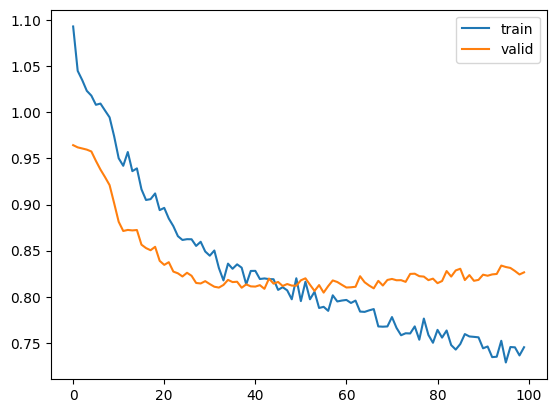

In [203]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.legend(['train', 'valid'])

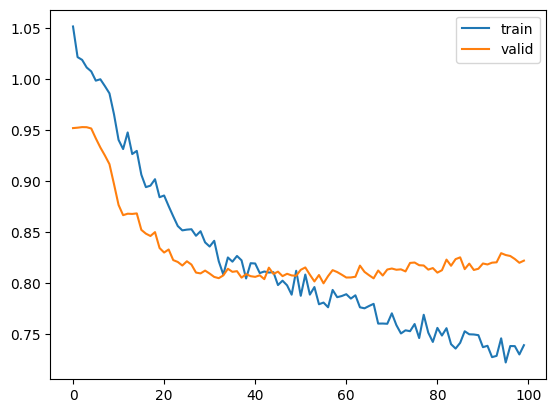

In [204]:
plt.plot(hist.history['mse'][0:])
plt.plot(hist.history['val_mse'][0:])
plt.legend(['train', 'valid'])

In [205]:
ypred = model.predict(xtest_ng, verbose=0)

In [206]:
from sklearn.metrics import mean_squared_error as mse, r2_score as r2
print(mse(ytest_ng, ypred))
print(mse(ytest_ng, ypred)**0.5)
print(r2(ytest_ng, ypred))

0.8588795402347158
0.9267575412343381
0.15072747670716818


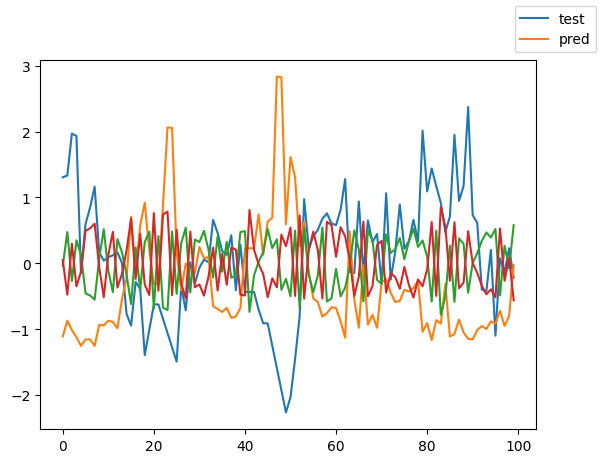

In [207]:
plt.show()
plt.plot(ytest[:100])
plt.plot(ypred[:100])
plt.figlegend(["test","pred"])

In [208]:
n_features = 21

In [209]:
xtrain[:int( len(xtrain)*0.8)].shape, ytrain[:int( len(xtrain)*0.8)].shape, numXTrain[:int( len(xtrain)*0.8)].shape

((2520, 8, 2), (2520, 2), (2520, 19))

In [210]:
valid = ([xtrain[int( len(xtrain)*0.8):], numXTrain[int( len(xtrain)*0.8):]], ytrain[int( len(xtrain)*0.8):])

In [211]:
from tensorflow.keras.layers import Input, LSTM, Dense, concatenate, Flatten
from tensorflow.keras.models import Model

# Define the input shapes
ts_input_shape = (8, 2)
num_input_shape = (19,)

# Define the time series input layer
ts_input_layer = Input(shape=ts_input_shape, name='ts_input')

# Define the LSTM layer for the time series input
lstm_output = LSTM(units=100, activation='relu', return_sequences=True)(ts_input_layer)
lstm_output_flat = Flatten()(lstm_output)

# Define the time series input layer
num_input_layer = Input(shape=num_input_shape, name='num_input')

# Concatenate the LSTM output and the numerical input
concatenated_inputs = concatenate([lstm_output_flat, num_input_layer], axis=-1)

# Apply a series of dense layers to the concatenated inputs
dense_output = Dense(units=120, activation='leaky_relu', kernel_regularizer=L2(0.001))(concatenated_inputs)
dense_output = Dense(units=100, activation='leaky_relu', kernel_regularizer=L2(0.01))(dense_output)
dense_output = Dense(units=100, activation='leaky_relu', kernel_regularizer=L2(0.01))(dense_output)
dense_output = Dropout(rate=0.5)(dense_output)

dense_output = Dense(units=50, activation='leaky_relu', kernel_regularizer=L2(0.01))(dense_output)
dense_output = Dense(units=50, activation='leaky_relu', kernel_regularizer=L2(0.01))(dense_output)
dense_output = Dropout(rate=0.5)(dense_output)

dense_output = Dense(units=30, activation='leaky_relu', kernel_regularizer=L2(0.01))(dense_output)
dense_output = Dense(units=30, activation='leaky_relu', kernel_regularizer=L2(0.01))(dense_output)
dense_output = Dropout(rate=0.5)(dense_output)

dense_output = Dense(units=30, activation='leaky_relu', kernel_regularizer=L2(0.01))(dense_output)

# Define the output layer
output_layer = Dense(units=2, activation='leaky_relu')(dense_output)

# Define the model with both inputs and the output
model = Model(inputs=[ts_input_layer, num_input_layer], outputs=output_layer)

# Compile the model
model.compile(optimizer='adam', loss='mse', metrics='mse')

# Print the model summary
model.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 ts_input (InputLayer)          [(None, 8, 2)]       0           []                               
                                                                                                  
 lstm_2 (LSTM)                  (None, 8, 100)       41200       ['ts_input[0][0]']               
                                                                                                  
 flatten_2 (Flatten)            (None, 800)          0           ['lstm_2[0][0]']                 
                                                                                                  
 num_input (InputLayer)         [(None, 19)]         0           []                               
                                                                                            

In [212]:
hist = model.fit([xtrain[:int( len(xtrain)*0.8)], numXTrain[:int( len(xtrain)*0.8)]], ytrain[:int( len(xtrain)*0.8)], validation_data=valid, epochs=100, verbose=2)

Epoch 1/100
79/79 - 4s - loss: 3.6043 - mse: 1.0097 - val_loss: 2.1424 - val_mse: 0.8536 - 4s/epoch - 54ms/step
Epoch 2/100
79/79 - 1s - loss: 1.7427 - mse: 0.9936 - val_loss: 1.2530 - val_mse: 0.8619 - 876ms/epoch - 11ms/step
Epoch 3/100
79/79 - 1s - loss: 1.2119 - mse: 0.9615 - val_loss: 1.0434 - val_mse: 0.8871 - 1s/epoch - 13ms/step
Epoch 4/100
79/79 - 1s - loss: 1.0527 - mse: 0.9358 - val_loss: 1.0061 - val_mse: 0.9157 - 1s/epoch - 14ms/step
Epoch 5/100
79/79 - 1s - loss: 1.0057 - mse: 0.9287 - val_loss: 0.9701 - val_mse: 0.9022 - 973ms/epoch - 12ms/step
Epoch 6/100
79/79 - 1s - loss: 0.9795 - mse: 0.9152 - val_loss: 0.9583 - val_mse: 0.8993 - 886ms/epoch - 11ms/step
Epoch 7/100
79/79 - 1s - loss: 0.9806 - mse: 0.9221 - val_loss: 0.9921 - val_mse: 0.9319 - 1s/epoch - 13ms/step
Epoch 8/100
79/79 - 1s - loss: 0.9737 - mse: 0.9177 - val_loss: 0.9372 - val_mse: 0.8807 - 1s/epoch - 13ms/step
Epoch 9/100
79/79 - 1s - loss: 0.9688 - mse: 0.9089 - val_loss: 0.9518 - val_mse: 0.8946 - 764m

In [213]:
model.load_weights(checkpoint_filepath)

ValueError: Received incompatible tensor with shape (40,) when attempting to restore variable with shape (120,) and name dense_42/bias:0.

In [214]:
hist.history.keys()

dict_keys(['loss', 'mse', 'val_loss', 'val_mse'])

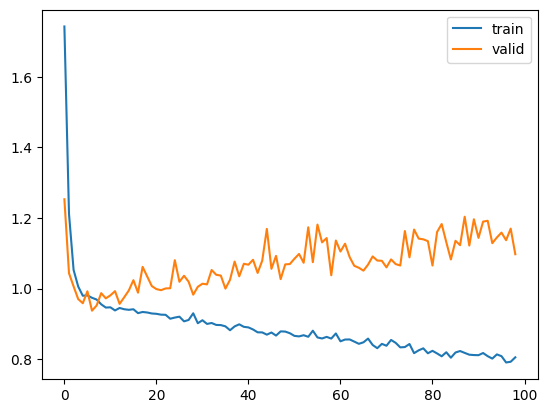

In [215]:
plt.plot(hist.history['loss'][1:])
plt.plot(hist.history['val_loss'][1:])
plt.legend(['train', 'valid'])

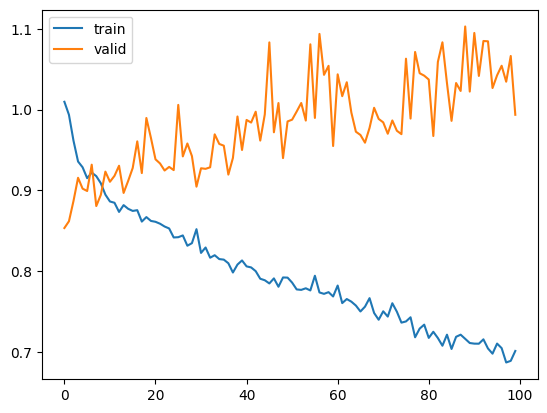

In [216]:
plt.plot(hist.history['mse'])
plt.plot(hist.history['val_mse'])
plt.legend(['train', 'valid'])

In [217]:
ypred = model.predict([xtest, numXTest], verbose=0)

In [218]:
from sklearn.metrics import mean_squared_error as mse
print(mse(ytest, ypred))
print(mse(ytest, ypred)**0.5)
print(r2(ytest, ypred))

1.2469380927280942
1.1166638226109478
-0.20969173894228588


In [219]:
ytest[:100,0]

array([ 1.30599021,  1.33292937,  1.97048938,  1.93457051, -0.14872419,
        0.59659245,  0.84802457,  1.16231472,  0.16556596,  0.0398499 ,
        0.09372821,  0.12066737,  0.16556596,  0.00393103, -0.76832476,
       -0.94791913, -0.28341996, -0.39117659, -1.39690506, -1.01077716,
       -0.62464927, -0.62585736, -0.84331351, -1.06076966, -1.27822581,
       -1.49568196, -0.35525771, -0.71444645,  0.01291075, -0.31035912,
       -0.06790672,  0.05780934,  0.01291075,  0.65945048,  0.46189667,
        0.1835254 ,  0.12964709,  0.4259778 , -0.40913602,  0.2823023 ,
       -0.43607518, -0.43607518, -0.43607518, -0.70546673, -0.91200026,
       -0.91388089, -1.25239511, -1.59090933, -1.92942354, -2.26793776,
       -2.03446507, -1.45976309, -0.81322336,  0.97374063,  0.22842399,
        0.40801836,  0.50679527,  0.67740992,  0.75822738,  0.60557217,
        0.57863301,  0.8121057 ,  1.27905106, -0.13076475, -0.14872419,
        0.93782175, -0.13974447,  0.65047076,  0.31822118,  0.44

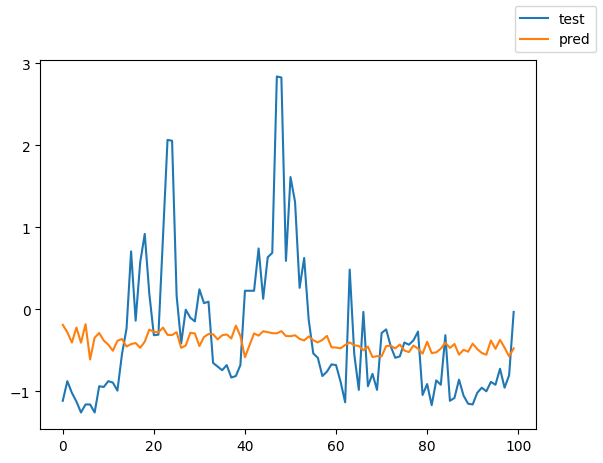

In [220]:
plt.plot(ytest[:100,1])
plt.plot(ypred[:100,1])
plt.figlegend(["test","pred"])

In [221]:
data

,% Iron Feed,% Silica Feed,Starch Flow,Amina Flow,Ore Pulp Flow,Ore Pulp pH,Ore Pulp Density,Flotation Column 01 Air Flow,Flotation Column 02 Air Flow,Flotation Column 03 Air Flow,...,Flotation Column 07 Air Flow,Flotation Column 01 Level,Flotation Column 02 Level,Flotation Column 03 Level,Flotation Column 04 Level,Flotation Column 05 Level,Flotation Column 06 Level,Flotation Column 07 Level,% Iron Concentrate,% Silica Concentrate
date,,,,,,,,,,,,,,,,,,,,,
2017-03-29 12:00:00,60.18,9.34,2044.990000,349.911,405.625000,9.74604,1.649650,200.393,195.734,201.826,...,251.002,555.264467,552.255566,614.984714,428.430,413.662,447.887,464.869,66.44,1.36
2017-03-29 13:00:00,60.18,9.34,2510.360000,306.635,402.303000,9.63786,1.524512,200.165,194.286,201.929,...,250.188,851.772761,809.863864,881.307250,447.543,421.279,446.697,413.322,66.57,1.43
2017-03-29 14:00:00,60.18,9.34,2138.230000,435.199,401.953000,9.61320,1.594940,199.540,197.436,198.605,...,250.488,850.510694,774.266870,886.773000,470.638,455.341,457.393,456.480,66.64,1.33
2017-03-29 15:00:00,60.18,9.34,458.079000,476.878,400.173000,9.75149,1.638440,199.951,191.456,199.265,...,249.582,858.052225,778.343085,883.777182,438.033,446.859,423.184,483.157,66.41,1.27
2017-03-29 16:00:00,59.54,9.56,145.349632,252.088,399.484000,9.96978,1.521080,199.072,182.430,201.251,...,250.760,853.745107,782.419299,883.715800,435.285,434.663,452.469,436.865,63.63,5.50
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-09-09 19:00:00,49.75,23.20,2888.060000,494.990,376.468000,9.27990,1.667860,317.065,297.754,301.685,...,302.330,577.943000,489.959000,504.995000,440.587,481.295,434.701,401.796,65.05,1.65
2017-09-09 20:00:00,49.75,23.20,4218.570000,492.027,378.630000,9.15799,1.648880,302.081,301.348,300.543,...,342.615,412.491000,510.388000,342.202000,371.883,594.518,443.687,375.044,64.83,1.71
2017-09-09 21:00:00,49.75,23.20,3159.100000,520.986,381.468667,9.58069,1.736200,296.063,298.480,299.085,...,332.393,401.456000,533.409000,390.060000,395.463,587.855,489.406,504.982,64.29,1.80


In [222]:
from sklearn.pipeline import Pipeline
from feature_engine.selection import DropConstantFeatures, DropDuplicateFeatures,SmartCorrelatedSelection
pip = Pipeline([('constant', DropConstantFeatures(tol=0.90)), ('duplicate', DropDuplicateFeatures()), ('correlated', SmartCorrelatedSelection(threshold=0.8))])

df = pip.fit_transform(data.drop(['% Iron Concentrate','% Silica Concentrate'], axis=1))

In [223]:
df['% Iron Concentrate'] = data['% Iron Concentrate']
df['% Silica Concentrate'] = data['% Silica Concentrate']
df = df.reset_index()

In [224]:
df

,date,% Silica Feed,Starch Flow,Amina Flow,Ore Pulp Flow,Ore Pulp pH,Ore Pulp Density,Flotation Column 03 Air Flow,Flotation Column 04 Air Flow,Flotation Column 05 Air Flow,Flotation Column 06 Air Flow,Flotation Column 01 Level,Flotation Column 02 Level,Flotation Column 03 Level,Flotation Column 04 Level,Flotation Column 05 Level,Flotation Column 06 Level,Flotation Column 07 Level,% Iron Concentrate,% Silica Concentrate
0,2017-03-29 12:00:00,9.34,2044.990000,349.911,405.625000,9.74604,1.649650,201.826,295.096,306.400,250.601,555.264467,552.255566,614.984714,428.430,413.662,447.887,464.869,66.44,1.36
1,2017-03-29 13:00:00,9.34,2510.360000,306.635,402.303000,9.63786,1.524512,201.929,295.096,306.400,250.194,851.772761,809.863864,881.307250,447.543,421.279,446.697,413.322,66.57,1.43
2,2017-03-29 14:00:00,9.34,2138.230000,435.199,401.953000,9.61320,1.594940,198.605,295.096,306.400,250.460,850.510694,774.266870,886.773000,470.638,455.341,457.393,456.480,66.64,1.33
3,2017-03-29 15:00:00,9.34,458.079000,476.878,400.173000,9.75149,1.638440,199.265,295.096,306.400,247.809,858.052225,778.343085,883.777182,438.033,446.859,423.184,483.157,66.41,1.27
4,2017-03-29 16:00:00,9.56,145.349632,252.088,399.484000,9.96978,1.521080,201.251,295.096,306.400,250.488,853.745107,782.419299,883.715800,435.285,434.663,452.469,436.865,63.63,5.50
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3943,2017-09-09 19:00:00,23.20,2888.060000,494.990,376.468000,9.27990,1.667860,301.685,300.583,300.593,297.551,577.943000,489.959000,504.995000,440.587,481.295,434.701,401.796,65.05,1.65
3944,2017-09-09 20:00:00,23.20,4218.570000,492.027,378.630000,9.15799,1.648880,300.543,300.125,299.530,336.250,412.491000,510.388000,342.202000,371.883,594.518,443.687,375.044,64.83,1.71
3945,2017-09-09 21:00:00,23.20,3159.100000,520.986,381.468667,9.58069,1.736200,299.085,299.130,299.588,350.652,401.456000,533.409000,390.060000,395.463,587.855,489.406,504.982,64.29,1.80
3946,2017-09-09 22:00:00,23.20,3348.190000,511.961,379.684000,9.89000,1.737230,298.231,297.533,296.898,346.723,399.186000,520.956000,700.739000,422.519,585.371,474.397,385.606,64.25,1.96


In [225]:
import statsmodels.api as sm

# Separate time series and numerical data
ts_df = df[['date', '% Silica Concentrate', '% Iron Concentrate']]
num_df = df.drop(['% Silica Concentrate', '% Iron Concentrate'], axis = 1)

# Merge time series and numerical data
merged_df = pd.merge(ts_df, num_df, on='date')
merged_df = merged_df.set_index('date')

In [226]:
import pandas as pd
import numpy as np
import statsmodels.api as sm

# Separate time series and numerical data
ts_df = df[['date', '% Silica Concentrate', '% Iron Concentrate']]
num_df = df.drop(['% Silica Concentrate', '% Iron Concentrate'], axis = 1)

# Merge time series and numerical data
merged_df = pd.merge(ts_df, num_df, on='date')
merged_df = merged_df.set_index('date')

# Create lagged variables
for i in merged_df.columns:
    if i == 'date':
        continue
    merged_df[i+'_lag24'] = merged_df[i].shift(24)
    
# merged_df['y1_lag1'] = merged_df['y1'].shift(1)
# merged_df['x1_lag1'] = merged_df['x1'].shift(1)

# Remove NaN values
merged_df.dropna(inplace=True)
merged_df

# Define exogenous variables
exog = merged_df.drop(['% Silica Concentrate', '% Iron Concentrate', '% Silica Concentrate_lag24', '% Iron Concentrate_lag24'], axis = 1)
for i in exog.columns:
    if '_lag24' not in i:
        exog.drop(i, axis=1, inplace=True)

# Define endogenous variables
endog = merged_df[['% Silica Concentrate', '% Iron Concentrate', '% Silica Concentrate_lag24', '% Iron Concentrate_lag24']]

# Split data into training and testing sets
train_endog = endog[:-12]
test_endog = endog[-12:]

train_exog = exog[:-12]
test_exog = exog[-12:]

exog

,% Silica Feed_lag24,Starch Flow_lag24,Amina Flow_lag24,Ore Pulp Flow_lag24,Ore Pulp pH_lag24,Ore Pulp Density_lag24,Flotation Column 03 Air Flow_lag24,Flotation Column 04 Air Flow_lag24,Flotation Column 05 Air Flow_lag24,Flotation Column 06 Air Flow_lag24,Flotation Column 01 Level_lag24,Flotation Column 02 Level_lag24,Flotation Column 03 Level_lag24,Flotation Column 04 Level_lag24,Flotation Column 05 Level_lag24,Flotation Column 06 Level_lag24,Flotation Column 07 Level_lag24
date,,,,,,,,,,,,,,,,,
2017-03-30 12:00:00,9.34,2044.990000,349.911000,405.625000,9.74604,1.649650,201.826,295.096,306.400,250.601,555.264467,552.255566,614.984714,428.430,413.662,447.887,464.869
2017-03-30 13:00:00,9.34,2510.360000,306.635000,402.303000,9.63786,1.524512,201.929,295.096,306.400,250.194,851.772761,809.863864,881.307250,447.543,421.279,446.697,413.322
2017-03-30 14:00:00,9.34,2138.230000,435.199000,401.953000,9.61320,1.594940,198.605,295.096,306.400,250.460,850.510694,774.266870,886.773000,470.638,455.341,457.393,456.480
2017-03-30 15:00:00,9.34,458.079000,476.878000,400.173000,9.75149,1.638440,199.265,295.096,306.400,247.809,858.052225,778.343085,883.777182,438.033,446.859,423.184,483.157
2017-03-30 16:00:00,9.56,145.349632,252.088000,399.484000,9.96978,1.521080,201.251,295.096,306.400,250.488,853.745107,782.419299,883.715800,435.285,434.663,452.469,436.865
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-09-09 19:00:00,8.45,1404.620400,310.231000,377.984800,9.25512,1.630330,301.100,300.366,300.702,298.151,404.177000,484.576000,406.179000,471.566,407.757,391.491,418.866
2017-09-09 20:00:00,8.45,1083.102632,268.753000,379.613800,9.34977,1.579960,301.926,299.482,302.129,298.958,386.617000,498.046000,370.307000,416.520,382.618,412.517,409.059
2017-09-09 21:00:00,8.45,1483.016542,358.590000,381.588000,9.47146,1.686690,297.879,301.412,297.448,296.440,394.243000,504.467000,399.783000,416.098,405.886,397.637,406.733


In [227]:
model = sm.tsa.VARMAX(train_endog, exog=train_exog, order=(24,24), trend='c')
results = model.fit(maxiter=1, disp=True)

D:\lib\site-packages\statsmodels\tsa\statespace\varmax.py:161: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  warn('Estimation of VARMA(p,q) models is not generically robust,'
D:\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)


KeyboardInterrupt: 

In [ ]:
model = sm.tsa.VARMAX(train_endog, exog=train_exog, order=(24,24), trend='c')
results = model.fit(maxiter=10, disp=True)

In [ ]:
model = sm.tsa.VARMAX(train_endog, exog=train_exog, order=(24,24), trend='c')
results = model.fit(maxiter=100, disp=True)

In [ ]:
predictions = results.forecast(steps=len(test_endog), exog=test_exog)

# Evaluate model
mse1 = np.mean((predictions['% Silica Concentrate_hat'] - test_endog['% Silica Concentrate'])**2)
mse2 = np.mean((predictions['% Iron Concentrate_hat'] - test_endog['% Iron Concentrate'])**2)

In [ ]:
mse1, mse2